In [1]:
import yfinance as yf
import pandas as pd
# For data manipulation
from urllib.request import urlopen, Request
# To extract fundamental data
from bs4 import BeautifulSoup
def fundamental_metric(soup, metric):
    return soup.find(text = metric).find_next(class_='snapshot-td2').text
def get_fundamental_data(df):
    for symbol in df.index:
        try:
            url = ("http://finviz.com/quote.ashx?t=" + symbol.lower())
            soup = bs(requests.get(url).content) 
            for m in df.columns:                
                df.loc[symbol,m] = fundamental_metric(soup,m)                
        except Exception as e:
            print (symbol, 'not found')
    return df
stock_list = ['AMZN','GOOG','PG','KO','IBM','DG','XOM','KO','PEP','MT','NL','LPL']
metric = ['P/B',
'P/E',
'Forward P/E',
'PEG',
'Debt/Eq',
'EPS (ttm)',
'Dividend %',
'ROE',
'ROI',
'EPS Q/Q',
'Insider Own'
]
sp500_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].tolist()

df = pd.DataFrame(index=sp500_tickers,columns=metric)
df = get_fundamental_data(df)
def fundamental_factor_model_sp500(df):
    
    # Calculate the PE ratio, PB ratio, and PS ratio for each company
    pe_ratios = df['P/E']
    fpe_ratios = df['Forward P/E']
    peg_ratios = df['PEG']
    roi_ratios = df['ROI']

    # Combine the ratios into a single DataFrame
    ratios = pd.concat([pe_ratios, fpe_ratios, 
                        peg_ratios,roi_ratios], axis=1)
    ratios.columns = ['PE Ratio', 'FPE Ratio', 'PEG Ratio', 'ROI Ratio']

    # Calculate the composite score as a weighted average of the three ratios
    ratios['Composite Score'] = (0.25 * ratios['PE Ratio']) + (0.25 * ratios['FPE Ratio']) + (0.25 * ratios['PEG Ratio'])+ (0.25 * ratios['ROI Ratio'])

    # Sort the companies by composite score
    sorted_ratios = ratios.sort_values(by='Composite Score')

    # Determine the number of companies in the top and bottom 10% of the sorted list
    num_companies = len(sorted_ratios)
    top_10_pct = int(num_companies * 0.1)
    bottom_10_pct = int(num_companies * 0.9)

    # Select the top and bottom 10% of companies for a long-short portfolio
    top_stocks = sorted_ratios.index[:top_10_pct].tolist()
    bottom_stocks = sorted_ratios.index[bottom_10_pct:].tolist()

    return top_stocks, bottom_stocks
# Calculate the top and bottom companies for a long-short portfolio for the month of March 2023
start_date = '2023-03-01'
end_date = '2023-03-31'
top_stocks, bottom_stocks = fundamental_factor_model_sp500(df)
print("Top Stocks:", top_stocks)
print("Bottom Stocks:", bottom_stocks)

MMM not found
AOS not found
ABT not found
ABBV not found
ACN not found
ATVI not found
ADM not found
ADBE not found
ADP not found
AAP not found
AES not found
AFL not found
A not found
APD not found
AKAM not found
ALK not found
ALB not found
ARE not found
ALGN not found
ALLE not found
LNT not found
ALL not found
GOOGL not found
GOOG not found
MO not found
AMZN not found
AMCR not found
AMD not found
AEE not found
AAL not found
AEP not found
AXP not found
AIG not found
AMT not found
AWK not found
AMP not found
ABC not found
AME not found
AMGN not found
APH not found
ADI not found
ANSS not found
AON not found
APA not found
AAPL not found
AMAT not found
APTV not found
ACGL not found
ANET not found
AJG not found
AIZ not found
T not found
ATO not found
ADSK not found
AZO not found
AVB not found
AVY not found
BKR not found
BALL not found
BAC not found
BBWI not found
BAX not found
BDX not found
WRB not found
BRK.B not found
BBY not found
BIO not found
TECH not found
BIIB not found
BLK not found


In [2]:
# Define the start and end dates
start_date = '2022-01-01'
end_date = '2022-12-31'

# Download financial data for the top and bottom stocks
all_stocks = top_stocks + bottom_stocks
stock_data = yf.download(all_stocks, start=start_date, end=end_date, group_by='ticker')

[*********************100%***********************]  101 of 101 completed


In [4]:
# Calculate daily returns for each stock
returns = stock_data.xs('Adj Close', axis=1, level=1, drop_level=False).pct_change()
returns=returns.droplevel(1,axis=1)
# Calculate the correlation matrix
corr_matrix = returns.corr()
import numpy as np
# Find the stocks with the lowest correlation to each other
min_corr_stocks = []
min_corr = 1.0
for i, stock1 in enumerate(all_stocks):
    for j in range(i+1, len(all_stocks)):
        stock2 = all_stocks[j]
        corr = corr_matrix.loc[stock1, stock2]
        if corr < min_corr:
            min_corr = corr
            min_corr_stocks = [stock1, stock2]

# Separate the low-correlation stocks into long and short portfolios
long_portfolio = [stock for stock in top_stocks if stock in min_corr_stocks]
short_portfolio = [stock for stock in bottom_stocks if stock in min_corr_stocks]

# Calculate the weights for the long and short positions
long_weights = [1.0/len(long_portfolio)] * len(long_portfolio)
short_weights = [-1.0/len(short_portfolio)] * len(short_portfolio)

# Combine the long and short portfolios and weights
portfolio_stocks = long_portfolio + short_portfolio
portfolio_weights = long_weights + short_weights

# Calculate the daily returns for the portfolio
portfolio_returns = returns[portfolio_stocks].dot(portfolio_weights)

# Calculate the volatility of the portfolio
portfolio_volatility = np.std(portfolio_returns)

print("Low-correlation long-short portfolio volatility:", portfolio_volatility)

Low-correlation long-short portfolio volatility: 0.024980145555444196


In [9]:
snp500 = yf.download(['SPY'], start=start_date, end=end_date, group_by='ticker')
snp500_returns=snp500['Close'].pct_change()

[*********************100%***********************]  1 of 1 completed


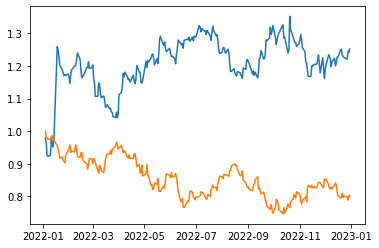

In [10]:
import matplotlib.pyplot as plt
plt.plot((portfolio_returns+1).cumprod())
plt.plot((snp500_returns+1).cumprod())
#Absolutely beat S&P500 